In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [16]:
data = pd.read_csv(r'C:\Users\adith\Desktop\WarLens\datasets\fatalities_isr_pse_conflict_2000_to_2023.csv')

In [17]:
data.head()

,name,date_of_event,age,citizenship,event_location,event_location_district,event_location_region,date_of_death,gender,took_part_in_the_hostilities,place_of_residence,place_of_residence_district,type_of_injury,ammunition,killed_by,notes
0,'Abd a-Rahman Suleiman Muhammad Abu Daghash,2023-09-24,32.0,Palestinian,Nur Shams R.C.,Tulkarm,West Bank,2023-09-24,M,NaN,Nur Shams R.C.,Tulkarm,gunfire,live ammunition,Israeli security forces,Fatally shot by Israeli forces while standing ...
1,Usayed Farhan Muhammad 'Ali Abu 'Ali,2023-09-24,21.0,Palestinian,Nur Shams R.C.,Tulkarm,West Bank,2023-09-24,M,NaN,Nur Shams R.C.,Tulkarm,gunfire,live ammunition,Israeli security forces,Fatally shot by Israeli forces while trying to...
2,'Abdallah 'Imad Sa'ed Abu Hassan,2023-09-22,16.0,Palestinian,Kfar Dan,Jenin,West Bank,2023-09-22,M,NaN,al-Yamun,Jenin,gunfire,live ammunition,Israeli security forces,Fatally shot by soldiers while firing at them ...
3,Durgham Muhammad Yihya al-Akhras,2023-09-20,19.0,Palestinian,'Aqbat Jaber R.C.,Jericho,West Bank,2023-09-20,M,NaN,'Aqbat Jaber R.C.,Jericho,gunfire,live ammunition,Israeli security forces,Shot in the head by Israeli forces while throw...
4,Raafat 'Omar Ahmad Khamaisah,2023-09-19,15.0,Palestinian,Jenin R.C.,Jenin,West Bank,2023-09-19,M,NaN,Jenin,Jenin,gunfire,live ammunition,Israeli security forces,Wounded by soldiers’ gunfire after running awa...


In [18]:
def handle_missing_values(df):
    print("Missing values before handling:")
    print(df.isnull().sum())
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    
    categorical_columns = df.select_dtypes(include=[object]).columns
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])
    
    print("\nMissing values after handling:")
    print(df.isnull().sum())
    return df

data = handle_missing_values(data)

Missing values before handling:
name                               0
date_of_event                      0
age                              129
citizenship                        0
event_location                     0
event_location_district            0
event_location_region              0
date_of_death                      0
gender                            20
took_part_in_the_hostilities    1430
place_of_residence                68
place_of_residence_district       68
type_of_injury                   291
ammunition                      5253
killed_by                          0
notes                            280
dtype: int64

Missing values after handling:
name                            0
date_of_event                   0
age                             0
citizenship                     0
event_location                  0
event_location_district         0
event_location_region           0
date_of_death                   0
gender                          0
took_part_in_the_hostilit

In [25]:
X = data.iloc[:, [i for i in range(data.shape[1]) if i != 14]]
y = data.iloc[:, 14]

In [26]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (11124, 15)
Shape of y: (11124,)


In [27]:
X = pd.get_dummies(X)

In [28]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [29]:
classes = label_encoder.classes_
num_classes = len(classes)

In [30]:
print("Target classes:", classes)
print("Number of classes:", num_classes)

Target classes: ['Israeli civilians' 'Israeli security forces' 'Palestinian civilians']
Number of classes: 3


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [34]:
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [35]:
input_shape = (X_train.shape[1],)
model_dense = create_model(input_shape, num_classes)
model_wider = create_model(input_shape, num_classes)
model_deeper = create_model(input_shape, num_classes)
model_dropout = create_model(input_shape, num_classes)

In [36]:
models = {
    'Dense': model_dense,
    'Wider': model_wider,
    'Deeper': model_deeper,
    'Dropout': model_dropout
}

for name, model in models.items():
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
histories = {}
for name, model in models.items():
    print(f"Training {name} model...")
    history = model.fit(X_train_scaled, y_train_cat, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
    histories[name] = history

Training Dense model...
Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8827 - loss: 0.3418 - val_accuracy: 0.9758 - val_loss: 0.0892
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9872 - loss: 0.0613 - val_accuracy: 0.8994 - val_loss: 0.2276
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9947 - loss: 0.0146 - val_accuracy: 0.9551 - val_loss: 0.1417
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.8876 - val_loss: 0.2630
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9982 - loss: 0.0055 - val_accuracy: 0.9140 - val_loss: 0.2052
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9986 - loss: 0.0095 - val_accuracy: 0.9416 - val_loss: 0.1635
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.8961 - val_loss: 0.2260
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 

In [38]:
def evaluate_model(model, X_test_scaled, y_test, y_test_cat, classes):
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred_classes)
    
    print("Classification Report:")
    print(classification_report(y_test_decoded, y_pred_decoded, target_names=classes))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_decoded, y_pred_decoded))
    
    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [39]:
for name, model in models.items():
    print(f"\nEvaluating {name} model:")
    evaluate_model(model, X_test_scaled, y_test, y_test_cat, classes)


Evaluating Dense model:
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
                         precision    recall  f1-score   support

      Israeli civilians       0.36      0.16      0.22        25
Israeli security forces       0.98      0.99      0.99      1996
  Palestinian civilians       0.97      0.85      0.91       204

               accuracy                           0.97      2225
              macro avg       0.77      0.67      0.70      2225
           weighted avg       0.97      0.97      0.97      2225

Confusion Matrix:
[[   4   20    1]
 [   6 1986    4]
 [   1   30  173]]
Test Accuracy: 0.9721

Evaluating Wider model:
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
                         precision    recall  f1-score   support

      Israeli civilians       0.83      0.20      0.32        25
Israeli security forces       0.98      1.00      0.99      1996
  Palestinian civilians       0.98      0.88      0.93       204

           

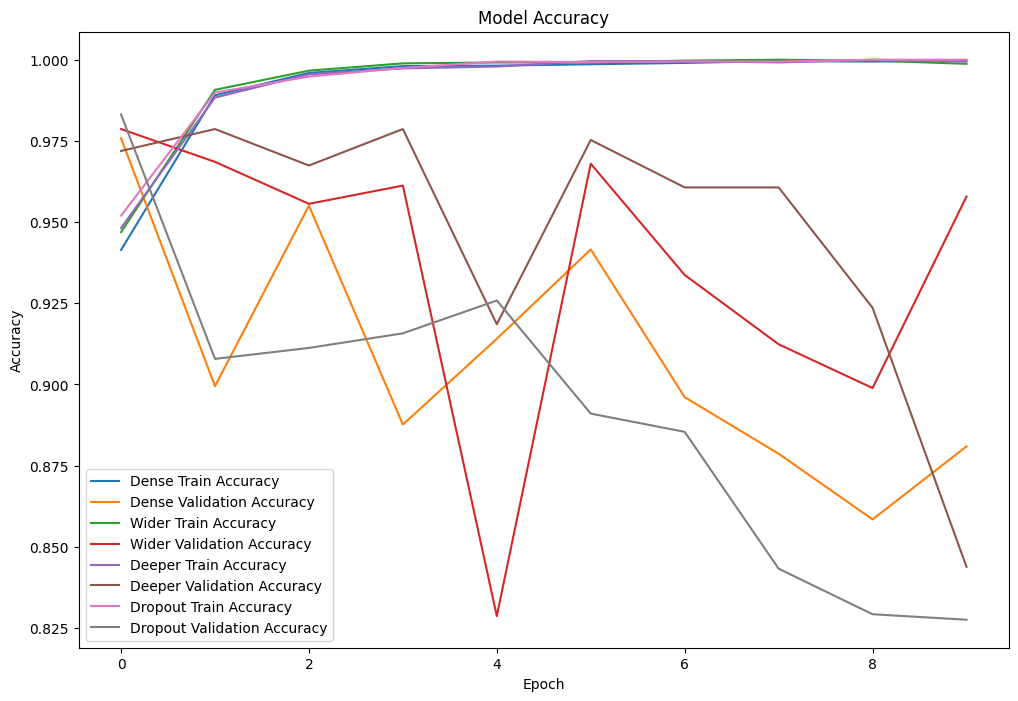

In [40]:
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{name} Validation Accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

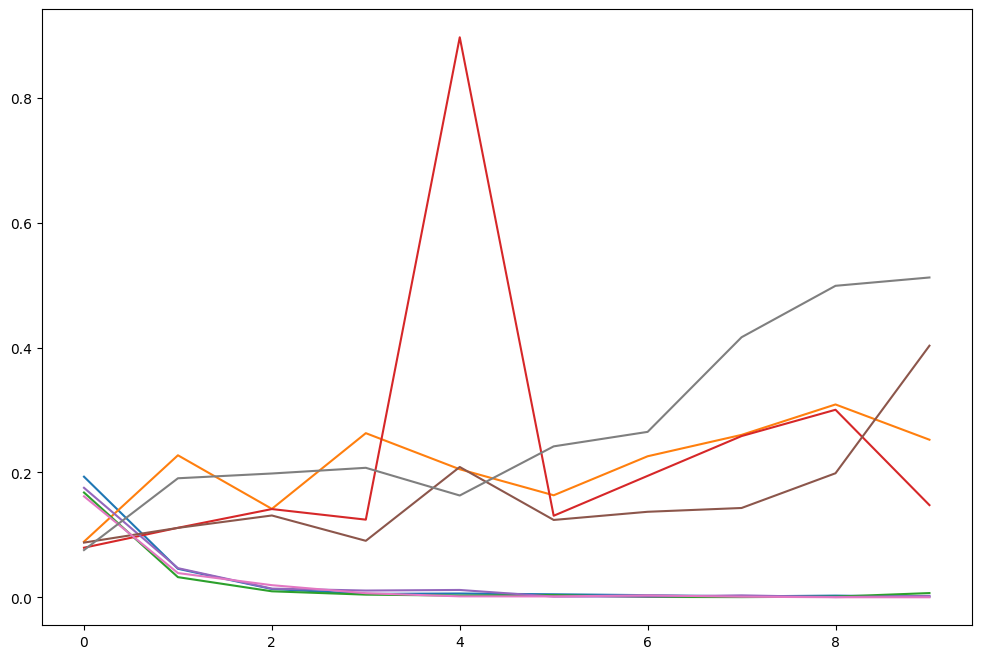

In [41]:
plt.figure(figsize=(12, 8))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')

C:\Users\adith\AppData\Local\Temp\ipykernel_25004\65916247.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


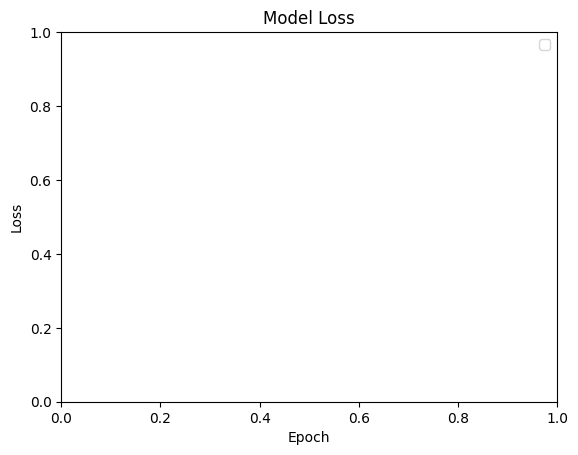

In [42]:
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()